### In this notebook, we created some models to identify fake and true news, and labelled the topics of each news. Because the data amount is too large, we used the title of each news for clissification.

#### 1. We first executed data cleaning - removed some stopwords and punctuations. etc.
#### 2. Then, we executed feature engineering - converted documents into word2ved, and used svd for dimension reduction.
#### 3. We created some baseline models(logistic regression, etc) and advanced models(LTSM and RNN) for clissification.
#### 4. We executed topic modelling to realize the main topics of fake and true news respectively. 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from keras.preprocessing import text, sequence
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout
from keras.callbacks import ReduceLROnPlateau
import tensorflow as tf
from google.colab import files

In [2]:
auploaded = files.upload()

Saving True.csv to True.csv


In [3]:
auploaded = files.upload()

Saving Fake.csv to Fake.csv


In [71]:
data_t = pd.read_csv('True.csv', parse_dates=['date'])
data_f = pd.read_csv('Fake.csv', parse_dates=['date'])

In [28]:
data_t

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,2017-12-31
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,2017-12-29
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,2017-12-31
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,2017-12-30
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,2017-12-29
...,...,...,...,...
21412,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,2017-08-22
21413,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,2017-08-22
21414,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,2017-08-22
21415,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,2017-08-22


In [6]:
data_f

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"
...,...,...,...,...
23476,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016"
23477,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016"
23478,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016"
23479,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016"


## Data Cleaning

In [72]:
data_f = data_f[['title','text']]
data_t = data_t[['title','text']]

In [73]:
data_f['authentic'] = 0
data_t['authentic'] = 1

In [74]:
data_f = data_f.sample(frac=0.4, replace=True, random_state=1)
data_t = data_t.sample(frac=0.4, replace=True, random_state=1)

In [75]:
data_t

,title,text,authentic
235,U.S. House committee 'may reconsider' WHO canc...,LONDON (Reuters) - U.S. congressional committe...,1
12172,'Congratulations': EU moves to Brexit phase tw...,BRUSSELS (Reuters) - The European Union agreed...,1
5192,White House aides told to preserve materials i...,WASHINGTON (Reuters) - The White House counsel...,1
17289,U.S. 'very concerned' by violence around Iraq'...,WASHINGTON (Reuters) - The U.S. State Departme...,1
10955,Obama's move on gender pay gap seen as first s...,NEW YORK (Reuters) - Advocates fighting to clo...,1
...,...,...,...
2108,Trump considering options for new Afghanistan ...,WASHINGTON (Reuters) - President Donald Trump ...,1
9158,Trump fights release of video testimony in fra...,NEW YORK (Reuters) - Lawyers for Republican pr...,1
18228,Suicide bombing at southwest Pakistan shrine k...,"QUETTA, Pakistan (Reuters) - A suicide bombing...",1
10884,"Republicans Christie, Fiorina drop White House...",WASHINGTON (Reuters) - New Jersey Governor Chr...,1


In [76]:
data_f

,title,text,authentic
235,GOP Lawmaker: Republicans Are Freaking Out Ab...,Sen. Bob Corker (R-TN) is being defended by on...,0
12172,JUDGE JEANINE TELLS THE LEFT TO KNOCK IT OFF: ...,Judge Jeanine Pirro has had it with the left a...,0
5192,D’oh!: Trump Tells Crowd In Richest County In...,"While in Virginia, GOP presidential nominee Do...",0
17289,UNREAL! IRS USED ‘HUNDREDS OF LAWYERS’ TO HIDE...,So much for the promise of transparency from O...,0
10955,NAIVE NEWS ANCHOR Reporting On “Refugees” Gets...,This is so disturbing but such a wake up call ...,0
...,...,...,...
22843,"Have the US, Trump Really Abandoned ‘Regime Ch...","Member of the US-backed Free Syrian Army, Ale...",0
11906,YES! JUDGE JEANINE HAMMERS Hollywood Lefty Ros...,,0
10136,THE PURGE: NYC Mayor De Blasio to Review ‘All ...,THE PURGE CONTINUES THE NYC MAYOR has just ope...,0
5285,Trump Admits Democrats Are Hurting His Feelin...,Everyone knows Donald Trump is a thin-skinned ...,0


In [77]:
data_t

,title,text,authentic
235,U.S. House committee 'may reconsider' WHO canc...,LONDON (Reuters) - U.S. congressional committe...,1
12172,'Congratulations': EU moves to Brexit phase tw...,BRUSSELS (Reuters) - The European Union agreed...,1
5192,White House aides told to preserve materials i...,WASHINGTON (Reuters) - The White House counsel...,1
17289,U.S. 'very concerned' by violence around Iraq'...,WASHINGTON (Reuters) - The U.S. State Departme...,1
10955,Obama's move on gender pay gap seen as first s...,NEW YORK (Reuters) - Advocates fighting to clo...,1
...,...,...,...
2108,Trump considering options for new Afghanistan ...,WASHINGTON (Reuters) - President Donald Trump ...,1
9158,Trump fights release of video testimony in fra...,NEW YORK (Reuters) - Lawyers for Republican pr...,1
18228,Suicide bombing at southwest Pakistan shrine k...,"QUETTA, Pakistan (Reuters) - A suicide bombing...",1
10884,"Republicans Christie, Fiorina drop White House...",WASHINGTON (Reuters) - New Jersey Governor Chr...,1


In [78]:
frame = [data_t,data_f]

In [79]:
data = pd.concat(frame,ignore_index = True)

In [80]:
data

,title,text,authentic
0,U.S. House committee 'may reconsider' WHO canc...,LONDON (Reuters) - U.S. congressional committe...,1
1,'Congratulations': EU moves to Brexit phase tw...,BRUSSELS (Reuters) - The European Union agreed...,1
2,White House aides told to preserve materials i...,WASHINGTON (Reuters) - The White House counsel...,1
3,U.S. 'very concerned' by violence around Iraq'...,WASHINGTON (Reuters) - The U.S. State Departme...,1
4,Obama's move on gender pay gap seen as first s...,NEW YORK (Reuters) - Advocates fighting to clo...,1
...,...,...,...
17954,"Have the US, Trump Really Abandoned ‘Regime Ch...","Member of the US-backed Free Syrian Army, Ale...",0
17955,YES! JUDGE JEANINE HAMMERS Hollywood Lefty Ros...,,0
17956,THE PURGE: NYC Mayor De Blasio to Review ‘All ...,THE PURGE CONTINUES THE NYC MAYOR has just ope...,0
17957,Trump Admits Democrats Are Hurting His Feelin...,Everyone knows Donald Trump is a thin-skinned ...,0


In [36]:
import re
import nltk
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [37]:
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

In [38]:
# substitute U.S. to united states,remove"'s",website link https and .com,puctuations, and lower case all of them
data['title']=data['title'].apply(lambda x: re.sub('U.S.',"united states",x))\
.apply(lambda x: re.sub(r"\b's\b",'',x))\
.apply(lambda x: re.sub(r"http\S+",'',x))\
.apply(lambda x: re.sub(r"[\S]+\.com([\S]+)?",'',x))\
.apply(lambda x: re.sub(r'[^A-Za-z0-9]',' ',x)).str.lower()

data['text']=data['text'].apply(lambda x: re.sub('U.S.',"united states",x))\
.apply(lambda x: re.sub(r"\b's\b",'',x))\
.apply(lambda x: re.sub(r"http\S+",'',x))\
.apply(lambda x: re.sub(r"[\S]+\.com([\S]+)?",'',x))\
.apply(lambda x: re.sub(r'[^A-Za-z0-9]',' ',x)).str.lower()

In [39]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [40]:
stopwords = set(stopwords.words('english'))

stopwords_remove = ['not', "aren't", "couldn't", 'didn', "didn't", 'doesn', "doesn't",'don', "don't", "hadn't", 'hadn',
                      'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'mightn', "mightn't", 'mustn', "mustn't", 'needn',
                      "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't",
                      'wouldn', "wouldn't",]

stopwords = set(stopwords).difference(set(stopwords_remove))

added_stopwords = ["I'm", "These", "there", "Those", "those", 'My', "my","I've", "It's", 'I', 'It', 'it', 'As', 'they', 'A', 'a',
                   'They', 'You', 'He', 'She', 'There', 'there', 'those', 'Those', 'This',
                  'this', 'That', 'she', 'it', 'that', 'We', 'the', 'The', '&', 'i','I','us', 'Us', 'is',"I'd", "I'll", 'in', 'on', 'In', 'On', 'To', 'to', 'for', 'For']

stopwords = list(stopwords) + added_stopwords

In [41]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [42]:
# stemming and stopwords removal
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

data['title'] = data['title'].apply(nltk.word_tokenize)\
.apply(lambda x:[stemmer.stem(word) for word in x if not word in stopwords])

data['text'] = data['text'].apply(nltk.word_tokenize)\
.apply(lambda x:[lemmatizer.lemmatize(word) for word in x if not word in stopwords])

In [43]:
# 
data['title'] = data['title'].apply(" ".join)
data['text'] = data['text'].apply(" ".join)

In [44]:
data['title']

0       unit state hous committe may reconsid cancer a...
1           congratul eu move brexit phase two warn tough
2       white hous aid told preserv materi russia prob...
3       unit state concern violenc around iraq kirkuk ...
4       obama move gender pay gap seen first step uphi...
                              ...                        
8974    death alton sterl polic kill 114 black men far...
8975    horrif nation anthem sung trump ralli pianist ...
8976    conserv invent conspiraci theori blame white o...
8977             trump fan drive jeep crowd protest video
8978           beyonc let know true feel polic not apolog
Name: title, Length: 8979, dtype: object

In [45]:
data['text']

0       london reuters united state congressional comm...
1       brunited statesls reuters european union agree...
2       washington reuters white house counsel office ...
3       washington reuters united state state departme...
4       new york reuters advocate fighting close unite...
                              ...                        
8974    outraged protester taken street baton rouge lo...
8975    not nice criticize people per se attempting si...
8976    even crankiest section america right wing star...
8977    saturday afternoon group protester gathered ma...
8978    beyonc released song formation performed super...
Name: text, Length: 8979, dtype: object

In [46]:
data

,title,text,authentic
0,unit state hous committe may reconsid cancer a...,london reuters united state congressional comm...,1
1,congratul eu move brexit phase two warn tough,brunited statesls reuters european union agree...,1
2,white hous aid told preserv materi russia prob...,washington reuters white house counsel office ...,1
3,unit state concern violenc around iraq kirkuk ...,washington reuters united state state departme...,1
4,obama move gender pay gap seen first step uphi...,new york reuters advocate fighting close unite...,1
...,...,...,...
8974,death alton sterl polic kill 114 black men far...,outraged protester taken street baton rouge lo...,0
8975,horrif nation anthem sung trump ralli pianist ...,not nice criticize people per se attempting si...,0
8976,conserv invent conspiraci theori blame white o...,even crankiest section america right wing star...,0
8977,trump fan drive jeep crowd protest video,saturday afternoon group protester gathered ma...,0


## Feature engineering：

In [47]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from spacy.matcher import Matcher
from collections import Counter
import spacy
from spacy import displacy
from sklearn.metrics.pairwise import cosine_similarity
from itertools import product
import en_core_web_sm
from scipy.spatial.distance import cosine
import re
from spacy.tokens import Span 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.collocations import BigramCollocationFinder, BigramAssocMeasures
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
import math
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from random import sample
import random

### word2vec

In [48]:
import spacy.cli
spacy.cli.download("en_core_web_md")
import en_core_web_md

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


In [49]:
nlp = spacy.load("en_core_web_md")

In [50]:
data.head(2)

,title,text,authentic
0,unit state hous committe may reconsid cancer a...,london reuters united state congressional comm...,1
1,congratul eu move brexit phase two warn tough,brunited statesls reuters european union agree...,1


In [51]:
text = data['text'].to_list()

In [52]:
cleaned_text = []

for review in text:
    cleaned_doc = list(nlp(review).vector)
    cleaned_text.append(cleaned_doc)

### Dimension Reduction - SVD

In [53]:
from scipy.linalg import svd
from sklearn.decomposition import TruncatedSVD

In [54]:
svd = TruncatedSVD(n_components=50)
reduced_svd_features = svd.fit_transform(cleaned_text)
reduced_svd_features

array([[ 2.65101147e+00, -4.23371881e-01, -3.68385464e-01, ...,
        -2.80733407e-02, -5.54507934e-02,  4.94381040e-02],
       [ 2.77236223e+00, -7.16954544e-02, -3.16572905e-01, ...,
        -4.49279658e-02, -5.20683825e-02,  3.82959507e-02],
       [ 2.90644932e+00, -6.14970982e-01,  2.71581709e-01, ...,
         1.12392548e-02, -1.01359226e-01,  8.64021108e-02],
       ...,
       [ 2.93758368e+00,  1.20161690e-01, -1.41243383e-01, ...,
        -3.07902973e-02,  7.35158920e-02,  2.53284187e-03],
       [ 2.81576729e+00,  4.50105876e-01, -3.69753122e-01, ...,
         2.43089925e-02, -3.21504921e-02,  1.22159077e-02],
       [ 2.99025249e+00,  6.52623594e-01, -4.51611876e-01, ...,
         5.20319380e-02,  4.26695123e-02,  1.14674062e-01]], dtype=float32)

In [55]:
df_w2v = pd.DataFrame()

In [56]:
for i in range(len(cleaned_text)):
    df_w2v[i] = reduced_svd_features[i]

In [57]:
df_w2v = df_w2v.T

In [58]:
df_w2v['authentic'] = data['authentic']

In [59]:
df_w2v.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,authentic
0,2.651011,-0.423372,-0.368385,-0.188740,0.049016,-0.186625,0.321142,0.117379,-0.005716,0.125955,0.046099,-0.040472,0.033013,-0.221142,-0.062730,0.135097,-0.013973,-0.063196,-0.074204,-0.035731,0.000250,-0.020883,0.034327,-0.043631,0.098853,0.041139,-0.074200,-0.028073,-0.055451,0.049438,1
1,2.772362,-0.071695,-0.316573,0.034497,0.039515,0.278533,0.060765,0.233510,0.164275,-0.101954,0.082602,0.080954,-0.087191,-0.017635,0.041052,0.017412,-0.145560,-0.009922,-0.096119,-0.075208,-0.053012,-0.045825,-0.017976,0.027591,-0.008668,-0.107076,-0.005436,-0.044928,-0.052068,0.038296,1
2,2.906449,-0.614971,0.271582,-0.310778,-0.100192,-0.423467,0.357248,0.217411,-0.151170,0.021935,-0.032314,0.028351,0.058667,-0.079015,-0.032539,-0.180255,-0.023485,0.105960,0.098010,-0.032156,0.067808,0.014001,0.009026,-0.067679,-0.055885,0.034900,-0.043069,0.011239,-0.101359,0.086402,1
3,3.055506,-0.791440,0.320771,0.380504,0.042908,-0.158092,0.163061,-0.190455,-0.133109,0.039338,-0.257116,0.114862,0.259488,-0.125517,-0.006773,0.062990,0.204793,0.039086,-0.065665,0.031607,-0.037301,0.142566,-0.144489,-0.056194,0.057844,0.114014,0.049428,0.164070,0.017250,0.193990,1
4,2.941297,-0.194100,-0.801621,-0.218201,-0.001583,0.083773,0.167783,-0.060153,0.062050,-0.079091,0.156428,-0.195837,0.109958,0.000603,-0.049465,-0.050323,0.008536,0.154049,-0.070748,0.108263,-0.240337,0.021543,-0.040656,0.014627,0.008257,-0.008124,0.106391,-0.058028,-0.011466,0.062033,1


In [ ]:
# df_w2v.to_csv('df_w2v.csv') 
# files.download('df_w2v.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Modelling:

### Baseline models:

In [ ]:
### Logistic Regression:

In [ ]:
X = df_w2v.iloc[:,:-1]
y = df_w2v.iloc[:,-1]

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [ ]:
lr = LogisticRegression()

lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

print(f'Accuracy is {round(np.mean(y_pred == y_test),3)}')
print( f'Roc_auc score of prediction is {round(roc_auc_score(y_test, y_pred),3)}.')

Accuracy is 0.951
Roc_auc score of prediction is 0.952.


In [ ]:
### Random Forest:

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate

In [ ]:
num_cross_val = 5

In [ ]:
def clf_score(clf, x_train, y_train, label, train_scores, test_scores, cv=num_cross_val, n_jobs=-1):
    score = cross_validate(clf, x_train, y_train, scoring = 'r2', cv=cv, n_jobs=n_jobs,
                           return_train_score=True, return_estimator=True)
    train_scores.append(score['train_score'])
    test_scores.append(score['test_score'])
    labels.append(label)
    print(np.mean(score['test_score']))

In [ ]:
labels = []
train_scores = []
test_scores = []

In [ ]:
rf = RandomForestClassifier()
param_grid = { 
    'max_depth': [3,5,7,9],
    'min_samples_leaf': [3,5,8,10],
    'n_estimators': [100]
}
CV_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv= 10)
CV_rf.fit(X, y)

GridSearchCV(cv=10, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [3, 5, 7, 9],
                         'min_samples_leaf': [3, 5, 8, 10],
                         'n_estimators': [100]})

In [ ]:
CV_rf.best_params_

{'max_depth': 9, 'min_samples_leaf': 3, 'n_estimators': 100}

In [ ]:
rf = RandomForestClassifier(max_depth = 9, min_samples_leaf = 5, n_estimators = 100) 
clf_score(rf, X, y, 'RF1', train_scores, test_scores, n_jobs=-1)

0.7098261427647926


In [ ]:
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

print(f'Accuracy is {round(np.mean(y_pred == y_test),3)}')
print( f'Roc_auc score of prediction is {round(roc_auc_score(y_test, y_pred),3)}.')

Accuracy is 0.927
Roc_auc score of prediction is 0.927.


### Advenced models(LSTM and RNN):

#### Use 'title' column for modeling
- For this section, we only use 'title' column for modeling.
- We tried both RNN and LSTM, but the result of using 'title' column for modeling is not good. Our baseline logistic regression model gives us 0.95 accuracy; however, this part can only give us about 0.91 accuracy. Therefore, we decided to use 'text' column (article itself) for modeling.

In [ ]:
data

,title,text,authentic
0,unit state hous committe may reconsid cancer a...,london reuter unit state congression committe ...,1
1,congratul eu move brexit phase two warn tough,brunit statesl reuter european union agre frid...,1
2,white hous aid told preserv materi russia prob...,washington reuter white hous counsel offic sen...,1
3,unit state concern violenc around iraq kirkuk ...,washington reuter unit state state depart said...,1
4,obama move gender pay gap seen first step uphi...,new york reuter advoc fight close unit state g...,1
...,...,...,...
8974,death alton sterl polic kill 114 black men far...,outrag protest taken street baton roug lousian...,0
8975,horrif nation anthem sung trump ralli pianist ...,not nice critic peopl per se attempt sing one ...,0
8976,conserv invent conspiraci theori blame white o...,even crankiest section america right wing star...,0
8977,trump fan drive jeep crowd protest video,saturday afternoon group protest gather main r...,0


In [ ]:
from random import randint
from numpy import array, argmax, asarray, zeros
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Embedding

In [ ]:
# apply the word count function
from collections import Counter

def count_words(lines, delimiter=" "):
    
    words = Counter() # instantiate a Counter object called words
    for line in lines:
        for word in line.split(delimiter):
            words[word] += 1 # increment count for word
    return words

# apply the histograme function
def make_histogram(values, title=None,xlabel=None,ylabel=None, bins=30, x_size=15, y_size=6):
    plt.rcParams["figure.figsize"] = (x_size,y_size)
    plt.hist(values, bins=bins)
    
    if title:
        plt.title(title) # give the plot a title
        
    if xlabel:
        plt.xlabel(xlabel) # label the X axis
        
    if ylabel:
        plt.ylabel(ylabel) # label the Y axis
        
    plt.show() 

In [ ]:
counter = count_words(data['title'])
counter.most_common(20)

[('trump', 3071),
 ('video', 1685),
 ('state', 1116),
 ('unit', 887),
 ('say', 802),
 ('obama', 653),
 ('hillari', 487),
 ('hous', 413),
 ('watch', 406),
 ('presid', 400),
 ('clinton', 399),
 ('not', 373),
 ('republican', 369),
 ('white', 362),
 ('new', 346),
 ('senat', 327),
 ('call', 306),
 ('democrat', 303),
 ('elect', 276),
 ('vote', 276)]

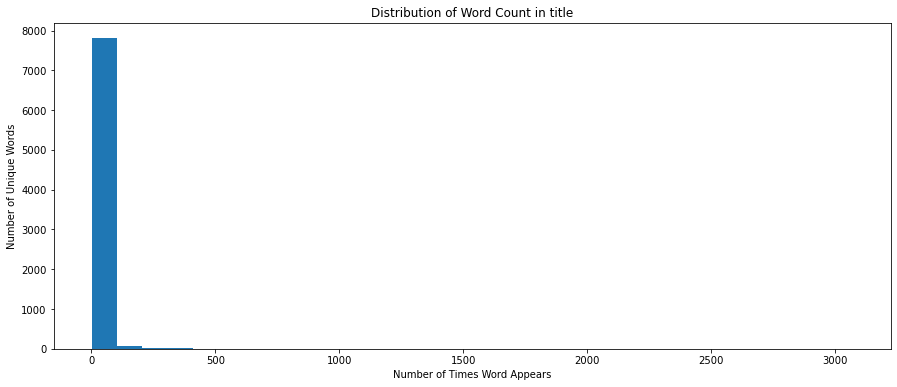

In [ ]:
import matplotlib.pyplot as plt
make_histogram(counter.values(), 
               title="Distribution of Word Count in title",
               xlabel="Number of Times Word Appears",
               ylabel="Number of Unique Words")

In [ ]:
len(counter)

7912

In [ ]:
from keras.preprocessing.text import text_to_word_sequence
from typing import List
def get_max_token_length_per_doc(docs: List[List[str]])-> int:
    return max(list(map(lambda x: len(x.split()), docs)))

# get the max length in terms of token length
max_length = get_max_token_length_per_doc(data['title'])
max_length

28

In [ ]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=8000, oov_token="UNKNOWN_TOKEN")
tokenizer.fit_on_texts(data['title'])

In [ ]:
VOCAB_SIZE = int(len(tokenizer.word_index) * 1.1)
MAX_SEQUENCE_LENGTH = 28

In [ ]:
def integer_encode_documents(docs, tokenizer):
    return tokenizer.texts_to_sequences(docs)

from tensorflow.keras.preprocessing.sequence import pad_sequences
# integer encode the documents
encoded_docs = integer_encode_documents(data['title'], tokenizer)

padded_docs = pad_sequences(encoded_docs, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

In [ ]:
from numpy import array
labels = array(data['authentic'])
labels

array([1, 1, 1, ..., 0, 0, 0], dtype=int64)

In [ ]:
def load_glove_vectors():
    embeddings_index = {}
    with open('glove.6B.100d.txt', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    print('Loaded %s word vectors.' % len(embeddings_index))
    return embeddings_index


embeddings_index = load_glove_vectors()

Loaded 400000 word vectors.


In [ ]:
# create a weight matrix for words in training docs
embedding_matrix = zeros((VOCAB_SIZE, 100))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: # check that it is an actual word that we have embeddings for
        embedding_matrix[i] = embedding_vector

In [ ]:
from keras.layers.recurrent import SimpleRNN, LSTM
from keras.layers import Flatten, Masking
# define model

def make_binary_classification_rnn_model(plot=False):
    model = Sequential()
    model.add(Embedding(VOCAB_SIZE, 100, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=False))
    model.add(Masking(mask_value=0.0)) # masking layer, masks any words that don't have an embedding as 0s.
    model.add(SimpleRNN(units=128, input_shape=(1, MAX_SEQUENCE_LENGTH)))
    model.add(Dense(16))
    model.add(Dense(2, activation='softmax'))
    
    # Compile the model
    model.compile(
    optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    # summarize the model
    model.summary()
    
    if plot:
        plot_model(model, to_file='model.png', show_shapes=True)
    return model

def make_lstm_classification_model(plot=False):
    model = Sequential()
    model.add(Embedding(VOCAB_SIZE, 100, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=False))
    model.add(Masking(mask_value=0.0)) # masking layer, masks any words that don't have an embedding as 0s.
    model.add(LSTM(units=64, input_shape=(1, MAX_SEQUENCE_LENGTH)))
    model.add(Dense(16))
    model.add(Dense(2, activation='softmax'))
    
    # Compile the model
    model.compile(
    optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    # summarize the model
    model.summary()
    
    if plot:
        plot_model(model, to_file='model.png', show_shapes=True)
    return model

In [ ]:
rnn_model = make_binary_classification_rnn_model()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 28, 100)           870300    
                                                                 
 masking_3 (Masking)         (None, 28, 100)           0         
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 128)               29312     
                                                                 
 dense_6 (Dense)             (None, 16)                2064      
                                                                 
 dense_7 (Dense)             (None, 2)                 34        
                                                                 
Total params: 901,710
Trainable params: 31,410
Non-trainable params: 870,300
_________________________________________________________________


In [ ]:
lstm_model = make_lstm_classification_model()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 28, 100)           870300    
                                                                 
 masking_4 (Masking)         (None, 28, 100)           0         
                                                                 
 lstm (LSTM)                 (None, 64)                42240     
                                                                 
 dense_8 (Dense)             (None, 16)                1040      
                                                                 
 dense_9 (Dense)             (None, 2)                 34        
                                                                 
Total params: 913,614
Trainable params: 43,314
Non-trainable params: 870,300
_________________________________________________________________


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(padded_docs, labels, test_size=0.3)

In [ ]:
rnn_model.fit(X_train, y_train, validation_split=0.3, epochs=10)

Epoch 1/10
138/138 [==============================] - 3s 13ms/step - loss: 0.3807 - accuracy: 0.8238 - val_loss: 0.3147 - val_accuracy: 0.8568
Epoch 2/10
138/138 [==============================] - 2s 11ms/step - loss: 0.2522 - accuracy: 0.8918 - val_loss: 0.2893 - val_accuracy: 0.8733
Epoch 3/10
138/138 [==============================] - 2s 11ms/step - loss: 0.2269 - accuracy: 0.9093 - val_loss: 0.3139 - val_accuracy: 0.8627
Epoch 4/10
138/138 [==============================] - 2s 11ms/step - loss: 0.1823 - accuracy: 0.9266 - val_loss: 0.3238 - val_accuracy: 0.8818
Epoch 5/10
138/138 [==============================] - 2s 11ms/step - loss: 0.1461 - accuracy: 0.9475 - val_loss: 0.3579 - val_accuracy: 0.8749
Epoch 6/10
138/138 [==============================] - 2s 12ms/step - loss: 0.1056 - accuracy: 0.9577 - val_loss: 0.3633 - val_accuracy: 0.8796
Epoch 7/10
138/138 [==============================] - 2s 14ms/step - loss: 0.0813 - accuracy: 0.9698 - val_loss: 0.6139 - val_accuracy: 0.8420

In [ ]:
lstm_model.fit(X_train, y_train, validation_split=0.3, epochs=10)

Epoch 1/10
138/138 [==============================] - 7s 29ms/step - loss: 0.3694 - accuracy: 0.8341 - val_loss: 0.2825 - val_accuracy: 0.8759
Epoch 2/10
138/138 [==============================] - 5s 34ms/step - loss: 0.2584 - accuracy: 0.8868 - val_loss: 0.2603 - val_accuracy: 0.8887
Epoch 3/10
138/138 [==============================] - 5s 33ms/step - loss: 0.2209 - accuracy: 0.9027 - val_loss: 0.2632 - val_accuracy: 0.8940
Epoch 4/10
138/138 [==============================] - 4s 32ms/step - loss: 0.1824 - accuracy: 0.9236 - val_loss: 0.2447 - val_accuracy: 0.9030
Epoch 5/10
138/138 [==============================] - 5s 33ms/step - loss: 0.1491 - accuracy: 0.9407 - val_loss: 0.2568 - val_accuracy: 0.9051
Epoch 6/10
138/138 [==============================] - 4s 32ms/step - loss: 0.1255 - accuracy: 0.9509 - val_loss: 0.2595 - val_accuracy: 0.9035
Epoch 7/10
138/138 [==============================] - 5s 35ms/step - loss: 0.1058 - accuracy: 0.9614 - val_loss: 0.2658 - val_accuracy: 0.9072

- The result of using 'title' column for modeling is not good. Our baseline logistic regression model gives us 0.95 accuracy; however, this part can only give us about 0.91 accuracy. Therefore, we decided to use 'text' column (article itself) for modeling.

#### Use 'text' column for modeling
- For this section, we used 'text' column for modeling.
- For RNN and LSTM models' parameters, we tried several combinations in testing and picked the most stable one for the final modeling.
- For Epoch, we first ran the model by setting epoch = 10. If we saw overfitting problem, we will decrease epoch number and chose the number shows the highest cross validation accuracy.
- In all attempts, LSTM shows a better result than RNN. Therefore, we decided to use LSTM.

In [ ]:
counter = count_words(data['text'])
counter.most_common(20)

[('trump', 27445),
 ('said', 26511),
 ('state', 22076),
 ('not', 16910),
 ('unit', 14832),
 ('presid', 12256),
 ('would', 11093),
 ('peopl', 8442),
 ('year', 8271),
 ('republican', 8153),
 ('one', 7863),
 ('say', 7499),
 ('elect', 6400),
 ('new', 6242),
 ('govern', 6239),
 ('clinton', 6164),
 ('hous', 6083),
 ('like', 6054),
 ('also', 6052),
 ('reuter', 5920)]

In [ ]:
len(counter)

40563

In [ ]:
# get the max length in terms of token length
max_length = get_max_token_length_per_doc(data['text'])
max_length

4889

In [ ]:
def get_token_length_per_doc(docs: List[List[str]])-> int:
    return list(map(lambda x: len(x.split()), docs))

length = get_token_length_per_doc(data['text'])

- There are about 40000 different tokens in the text column and the maximum length for text is about 5000.
- On this graph, we can see most text are shorter than 1000 words. Therefore, we decided to first try max_sequence = 1000 in modeling.

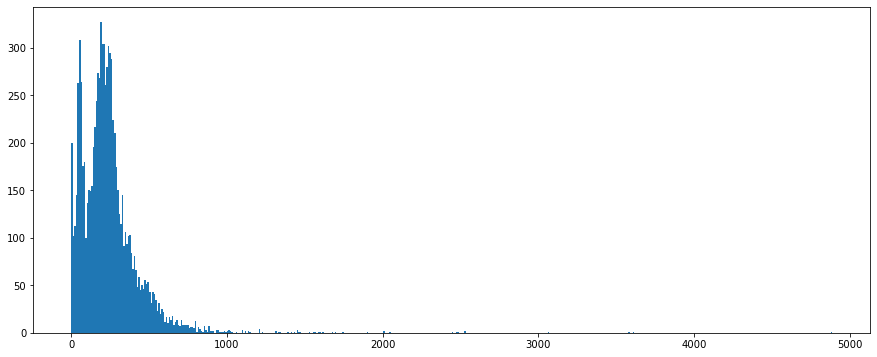

In [ ]:
plt.hist(length, bins=500)
plt.show()

##### Attempt 1: num_words = 10000, max_sequence_length = 1000
- Best model is LSTM(epoch=7). 
- We get test accuracy rate = 0.968, cross validation accuracy rate = 0.973.

In [ ]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=10000, oov_token="UNKNOWN_TOKEN")
tokenizer.fit_on_texts(data['text'])

VOCAB_SIZE = int(len(tokenizer.word_index) * 1.1)
MAX_SEQUENCE_LENGTH = 1000

In [ ]:
# integer encode the documents
encoded_docs = integer_encode_documents(data['text'], tokenizer)

padded_docs = pad_sequences(encoded_docs, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

In [ ]:
# create a weight matrix for words in training docs
embedding_matrix = zeros((VOCAB_SIZE, 100))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: # check that it is an actual word that we have embeddings for
        embedding_matrix[i] = embedding_vector

In [ ]:
# define model

def make_binary_classification_rnn_model(plot=False):
    model = Sequential()
    model.add(Embedding(VOCAB_SIZE, 100, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=False))
    model.add(Masking(mask_value=0.0)) # masking layer, masks any words that don't have an embedding as 0s.
    model.add(SimpleRNN(units=128, input_shape=(1, MAX_SEQUENCE_LENGTH)))
    model.add(Dense(32))
    model.add(Dense(2, activation='softmax'))
    
    # Compile the model
    model.compile(
    optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    # summarize the model
    model.summary()
    
    if plot:
        plot_model(model, to_file='model.png', show_shapes=True)
    return model

def make_lstm_classification_model(plot=False):
    model = Sequential()
    model.add(Embedding(VOCAB_SIZE, 100, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=False))
    model.add(Masking(mask_value=0.0)) # masking layer, masks any words that don't have an embedding as 0s.
    model.add(LSTM(units=64, input_shape=(1, MAX_SEQUENCE_LENGTH)))
    model.add(Dense(16))
    model.add(Dense(2, activation='softmax'))
    
    # Compile the model
    model.compile(
    optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    # summarize the model
    model.summary()
    
    if plot:
        plot_model(model, to_file='model.png', show_shapes=True)
    return model

In [ ]:
text_rnn_model = make_binary_classification_rnn_model()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 1000, 100)         4461900   
                                                                 
 masking_3 (Masking)         (None, 1000, 100)         0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 128)               29312     
                                                                 
 dense_6 (Dense)             (None, 32)                4128      
                                                                 
 dense_7 (Dense)             (None, 2)                 66        
                                                                 
Total params: 4,495,406
Trainable params: 33,506
Non-trainable params: 4,461,900
_________________________________________________________________


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(padded_docs, labels, test_size=0.3, random_state=0)

In [ ]:
text_rnn_model.fit(X_train, y_train, validation_split=0.3, epochs=10)

Epoch 1/10
138/138 [==============================] - 65s 462ms/step - loss: 0.3608 - accuracy: 0.8491 - val_loss: 0.3831 - val_accuracy: 0.8431
Epoch 2/10
138/138 [==============================] - 62s 453ms/step - loss: 0.2521 - accuracy: 0.9054 - val_loss: 0.2093 - val_accuracy: 0.9210
Epoch 3/10
138/138 [==============================] - 64s 461ms/step - loss: 0.1737 - accuracy: 0.9384 - val_loss: 0.2401 - val_accuracy: 0.9024
Epoch 4/10
138/138 [==============================] - 65s 469ms/step - loss: 0.1738 - accuracy: 0.9379 - val_loss: 0.2195 - val_accuracy: 0.9130
Epoch 5/10
138/138 [==============================] - 64s 467ms/step - loss: 0.1554 - accuracy: 0.9418 - val_loss: 0.2721 - val_accuracy: 0.9019
Epoch 6/10
138/138 [==============================] - 63s 458ms/step - loss: 0.1642 - accuracy: 0.9350 - val_loss: 0.4936 - val_accuracy: 0.8372
Epoch 7/10
138/138 [==============================] - 63s 454ms/step - loss: 0.3330 - accuracy: 0.8588 - val_loss: 0.3613 - val_ac

In [ ]:
# we first run the cell by setting epoch = 10, but we saw overfitting issue.
# we now set epoch = 7 because when epoch = 7 it gives us the highest cross validation accuracy.
text_lstm_model = make_lstm_classification_model()
text_lstm_model.fit(X_train, y_train, validation_split=0.3, epochs=7)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 1000, 100)         4461900   
                                                                 
 masking_6 (Masking)         (None, 1000, 100)         0         
                                                                 
 lstm_4 (LSTM)               (None, 64)                42240     
                                                                 
 dense_12 (Dense)            (None, 16)                1040      
                                                                 
 dense_13 (Dense)            (None, 2)                 34        
                                                                 
Total params: 4,505,214
Trainable params: 43,314
Non-trainable params: 4,461,900
_________________________________________________________________
Epoch 1/7
138/138 [====================

In [ ]:
# evaluate the model
loss, accuracy = text_lstm_model.evaluate(X_test, y_test, verbose=1)
print('Accuracy: %f' % (accuracy*100))

85/85 [==============================] - 20s 240ms/step - loss: 0.0973 - accuracy: 0.9681
Accuracy: 96.807718


##### Attempt 2: num_words = 10000, max_sequence_length = 300
- Best model is LSTM(epoch=10). 
- We get test accuracy rate = 0.972, cross validation accuracy rate = 0.969.

In [ ]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=10000, oov_token="UNKNOWN_TOKEN")
tokenizer.fit_on_texts(data['text'])

VOCAB_SIZE = int(len(tokenizer.word_index) * 1.1)
MAX_SEQUENCE_LENGTH = 300

# integer encode the documents
encoded_docs = integer_encode_documents(data['text'], tokenizer)

padded_docs = pad_sequences(encoded_docs, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

# create a weight matrix for words in training docs
embedding_matrix = zeros((VOCAB_SIZE, 100))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: # check that it is an actual word that we have embeddings for
        embedding_matrix[i] = embedding_vector
        
X_train, X_test, y_train, y_test = train_test_split(padded_docs, labels, test_size=0.3, random_state=0)

In [ ]:
text_lstm_model2 = make_lstm_classification_model()
text_lstm_model2.fit(X_train, y_train, validation_split=0.3, epochs=10)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 300, 100)          4461900   
                                                                 
 masking_7 (Masking)         (None, 300, 100)          0         
                                                                 
 lstm_5 (LSTM)               (None, 64)                42240     
                                                                 
 dense_14 (Dense)            (None, 16)                1040      
                                                                 
 dense_15 (Dense)            (None, 2)                 34        
                                                                 
Total params: 4,505,214
Trainable params: 43,314
Non-trainable params: 4,461,900
_________________________________________________________________
Epoch 1/10
138/138 [===================

In [ ]:
# evaluate the model
loss, accuracy = text_lstm_model2.evaluate(X_test, y_test, verbose=1)
print('Accuracy: %f' % (accuracy*100))

85/85 [==============================] - 6s 67ms/step - loss: 0.0893 - accuracy: 0.9722
Accuracy: 97.216034


##### Attempt 3: num_words = 20000, max_sequence_length = 300
- Best model is LSTM(epoch=10).
- We get test accuracy rate = 0.974, cross validation accuracy rate = 0.971.

In [ ]:
tokenizer = Tokenizer(num_words=20000, oov_token="UNKNOWN_TOKEN")
tokenizer.fit_on_texts(data['text'])

VOCAB_SIZE = int(len(tokenizer.word_index) * 1.1)
MAX_SEQUENCE_LENGTH = 300

# integer encode the documents
encoded_docs = integer_encode_documents(data['text'], tokenizer)

padded_docs = pad_sequences(encoded_docs, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

# create a weight matrix for words in training docs
embedding_matrix = zeros((VOCAB_SIZE, 100))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: # check that it is an actual word that we have embeddings for
        embedding_matrix[i] = embedding_vector
        
X_train, X_test, y_train, y_test = train_test_split(padded_docs, labels, test_size=0.3, random_state=0)

text_lstm_model3 = make_lstm_classification_model()
text_lstm_model3.fit(X_train, y_train, validation_split=0.3, epochs=10)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 300, 100)          4461900   
                                                                 
 masking_8 (Masking)         (None, 300, 100)          0         
                                                                 
 lstm_6 (LSTM)               (None, 64)                42240     
                                                                 
 dense_16 (Dense)            (None, 16)                1040      
                                                                 
 dense_17 (Dense)            (None, 2)                 34        
                                                                 
Total params: 4,505,214
Trainable params: 43,314
Non-trainable params: 4,461,900
_________________________________________________________________
Epoch 1/10
138/138 [===================

In [ ]:
history = pd.DataFrame()
history['loss'] = [0.2922, 0.2023, 0.1573, 0.1307, 0.2574, 0.1528, 0.1149, 0.0756, 0.0557, 0.0434]
history['accuracy'] = [0.8807, 0.9286, 0.9427, 0.9520, 0.8957, 0.9450, 0.9614, 0.9752, 0.9825, 0.9873]
history['val_loss'] = [0.2179, 0.1845, 0.1535, 0.1656, 0.2099, 0.1224, 0.1116, 0.0818, 0.0794, 0.0811]
history['val_accuracy'] = [0.9178, 0.9337, 0.9507, 0.9380, 0.9083, 0.9602, 0.9639, 0.9692, 0.9751, 0.9740]

In [ ]:
# evaluate the model
loss, accuracy = text_lstm_model3.evaluate(X_test, y_test, verbose=1)
print('Accuracy: %f' % (accuracy*100))

85/85 [==============================] - 4s 50ms/step - loss: 0.0870 - accuracy: 0.9714
Accuracy: 97.141796


- This model with num_words = 20000, max_sequence_length = 300, epoch = 10 gives us the best result.
- We decided pick this one as our final model.

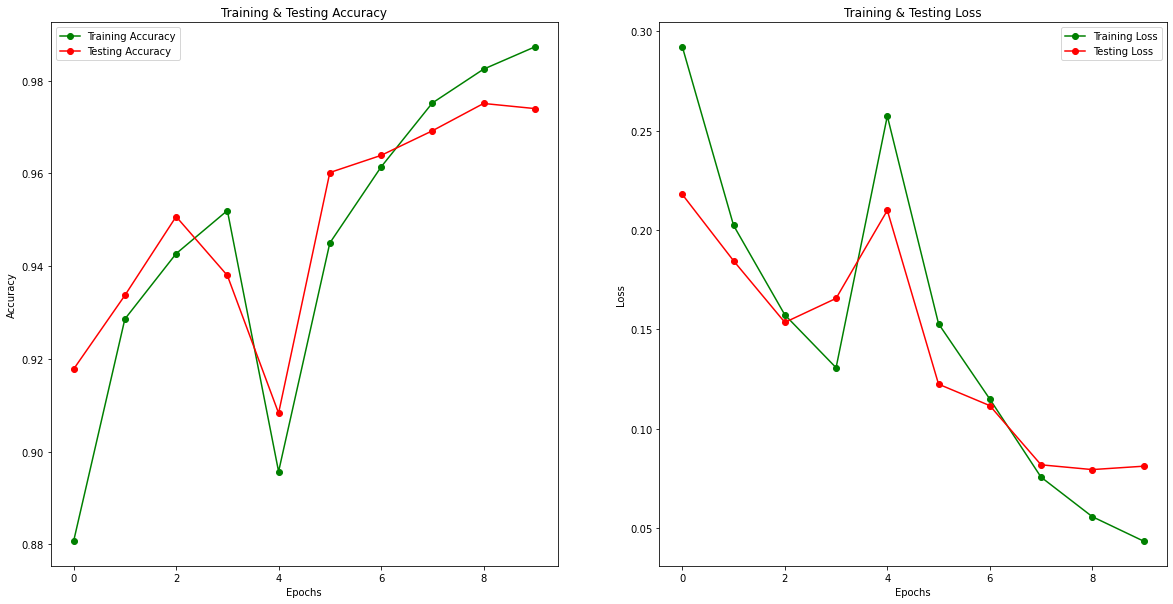

In [ ]:
epochs = [i for i in range(10)]
fig , ax = plt.subplots(1,2)
train_acc = history['accuracy']
train_loss = history['loss']
val_acc = history['val_accuracy']
val_loss = history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'ro-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

## Topic Modelling:

#### We first calculated the topics of all the fake and true news. Then, we got the topics of fake news and true news respectively. We finally compared the difference between topics of fake and true news.

### Topics of all news:
#### Step 1: Vectorize The Corpus

In [60]:
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(ngram_range=(2,2),
                             token_pattern=r'\b[a-zA-Z]{3,}\b', max_df=0.4, max_features = 1000, stop_words="english")

X, terms = vectorizer.fit_transform(data.text), vectorizer.get_feature_names_out()

df_tf_idf = pd.DataFrame(X.toarray(), columns=terms)

print(f"TF-IDF: {df_tf_idf.shape}")
df_tf_idf.head(5)

TF-IDF: (8979, 1000)


,abc news,according new,according report,according reuters,according united,administration official,advocacy group,affordable care,african american,agency said,aide said,air force,air strike,alex wong,alleged russian,alt right,alternate current,ambassador united,america great,american citizen,american flag,american free,american history,american people,american voter,angela merkel,answer question,anti corruption,anti trump,antonin scalia,appeal court,approval rating,arab emirate,armed force,armed service,asia pacific,asked trump,associated press,asylum seeker,attack united,...,washington post,washington reuters,washington state,wasserman schultz,watch video,wednesday night,week ago,week trump,went say,west bank,white house,white nationalist,white people,white supremacist,win election,wire say,witch hunt,woman child,woman march,woman right,won election,wong getty,working class,world leader,world power,world war,year according,year ago,year later,year old,year prison,year said,year trump,year united,year year,york businessman,york city,york reuters,york time,young people
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.154475,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.178991,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.358049,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.206014,0.0,0.0,...,0.0,0.099884,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.185056,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.225748,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.485193,0.0,0.0


#### Step 2: Fit NMF Model

In [61]:
nmf = NMF(n_components=5)
df_W = nmf.fit_transform(X)
df_H = nmf.components_
print(f"Original shape of X is {X.shape}")
print(f"Decomposed W matrix is {df_W.shape}")
print(f"Decomposed H matrix is {df_H.shape}")

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


Original shape of X is (8979, 1000)
Decomposed W matrix is (8979, 5)
Decomposed H matrix is (5, 1000)


#### Step 3: Report Results For Each Topic

In [62]:
from typing import List
import numpy as np

def get_top_tf_idf_tokens_for_topic(H: np.array, feature_names: List[str], num_top_tokens: int = 5):
  """
  Uses the H matrix (K components x M original features) to identify for each
  topic the most frequent tokens.
  """
  for topic, vector in enumerate(H):
    print(f"TOPIC {topic}\n")
    total = vector.sum()
    top_scores = vector.argsort()[::-1][:num_top_tokens]
    token_names = list(map(lambda idx: feature_names[idx], top_scores))
    strengths = list(map(lambda idx: vector[idx] / total, top_scores))
    
    for strength, token_name in zip(strengths, token_names):
      print(f"\b{token_name} ({round(strength * 100, 1)}%)\n")
    print(f"=" * 50)

get_top_tf_idf_tokens_for_topic(df_H, df_tf_idf.columns.tolist(), 15)

TOPIC 0

white house (5.2%)

washington reuters (2.2%)

president donald (1.8%)

reuters united (1.4%)

barack obama (1.4%)

state president (1.2%)

president barack (1.2%)

house said (1.1%)

trump said (1.0%)

trump administration (0.9%)

national security (0.8%)

house representative (0.8%)

said statement (0.7%)

obama administration (0.7%)

president trump (0.7%)

TOPIC 1

prime minister (5.5%)

european union (2.7%)

saudi arabia (2.0%)

islamic state (1.9%)

told reuters (1.5%)

london reuters (1.4%)

minister theresa (1.3%)

human right (1.2%)

official said (1.2%)

said statement (1.1%)

foreign minister (1.0%)

said thursday (1.0%)

united nation (1.0%)

said wednesday (0.9%)

told reporter (0.9%)

TOPIC 2

hillary clinton (8.6%)

new york (2.2%)

secretary state (1.9%)

bernie sander (1.5%)

presidential candidate (1.4%)

century wire (1.4%)

clinton campaign (1.4%)

state department (1.3%)

democratic presidential (1.0%)

clinton foun

#### Topic summary:
##### topic 1: News related to important people of American Presidential Election.
##### topic 2: News from social media, and many are related to Trump.
##### topic 3: News related to military events between North Koera, South Koera and United States.
##### topic 4: News related to American government announcement.
##### topic 5: News related to the political rivalry between Occiendt and middle east countries.

### Topic modelling for fake news:

In [63]:
vectorizer = TfidfVectorizer(ngram_range=(2,2),
                             token_pattern=r'\b[a-zA-Z]{3,}\b', max_df=0.4, max_features = 1000, stop_words="english")

X, terms = vectorizer.fit_transform(data.loc[data['authentic']==0,'text']), vectorizer.get_feature_names_out()

df_tf_idf = pd.DataFrame(X.toarray(), columns=terms)

print(f"TF-IDF: {df_tf_idf.shape}")
df_tf_idf.head(5)

TF-IDF: (4696, 1000)


,abc news,according new,according report,according washington,acr brain,acr host,acr live,active shooter,administration official,affordable care,african american,air force,alex wong,alt right,alternate current,amendment right,america great,american citizen,american flag,american history,american people,american public,american taxpayer,american voter,anderson cooper,andy nowicki,angela merkel,angeles time,angerer getty,animal lovable,ann coulter,answer question,anti american,anti gay,anti semitic,anti trump,antonin scalia,approval rating,art deal,ask question,...,wednesday night,week ago,week trump,went say,west virginia,white helmet,white house,white men,white nationalist,white people,white supremacist,white supremacy,wildlife refuge,wilson getty,win election,win mcnamee,wire say,witch hunt,woman child,woman march,woman right,won election,wong getty,word trump,work sunited,working class,world leader,world war,year ago,year later,year old,year prison,year trump,year year,york city,york post,york time,young man,young people,young woman
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.270151,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.521396,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.465942,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.287794,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.293673,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


In [64]:
nmf = NMF(n_components=5)
df_W = nmf.fit_transform(X)
df_H = nmf.components_
print(f"Original shape of X is {X.shape}")
print(f"Decomposed W matrix is {df_W.shape}")
print(f"Decomposed H matrix is {df_H.shape}")

Original shape of X is (4696, 1000)
Decomposed W matrix is (4696, 5)
Decomposed H matrix is (5, 1000)


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


In [65]:
get_top_tf_idf_tokens_for_topic(df_H, df_tf_idf.columns.tolist(), 15)

TOPIC 0

donald trump (6.6%)

featured image (2.2%)

getty image (1.4%)

trump supporter (1.1%)

ted cruz (1.0%)

fox news (1.0%)

trump realdonaldtrump (1.0%)

screen capture (0.9%)

trump campaign (0.9%)

trump said (0.9%)

image video (0.8%)

republican party (0.8%)

year old (0.7%)

video screen (0.7%)

president donald (0.6%)

TOPIC 1

united state (11.6%)

obama administration (1.3%)

state department (1.1%)

year old (1.1%)

president united (1.0%)

illegal alien (0.9%)

state government (0.9%)

barack obama (0.8%)

national security (0.8%)

president obama (0.7%)

breitbart news (0.7%)

illegal immigrant (0.7%)

new york (0.7%)

year ago (0.6%)

middle east (0.6%)

TOPIC 2

hillary clinton (14.4%)

secretary state (2.7%)

bernie sander (2.3%)

state department (2.1%)

clinton foundation (2.0%)

clinton campaign (1.8%)

email server (1.2%)

new york (1.2%)

private email (1.1%)

james comey (1.0%)

fbi director (1.0%)

clinton said (1.0%

#### Topic summary:
##### topic 1: News related to American Presidential Election, especially those related to Trump.
##### topic 2: News from social media, and many are related to Trump.
##### topic 3: News related to American Presidential Election, especially those related to Hillary Clinton .
##### topic 4: News related to American government announcements especially those of Obama.
##### topic 5: News related to "subscribing".(?????????)

### Topic modelling for True news:

In [66]:
vectorizer = TfidfVectorizer(ngram_range=(2,2),
                             token_pattern=r'\b[a-zA-Z]{3,}\b', max_df=0.4, max_features = 1000, stop_words="english")

X, terms = vectorizer.fit_transform(data.loc[data['authentic']==1,'text']), vectorizer.get_feature_names_out()

df_tf_idf = pd.DataFrame(X.toarray(), columns=terms)

print(f"TF-IDF: {df_tf_idf.shape}")
df_tf_idf.head(5)

TF-IDF: (4283, 1000)


,according reuters,according united,adam schiff,administration official,administration said,adviser michael,advocacy group,affordable care,african american,agency reported,agency said,aid worker,aide said,air base,air force,air strike,alleged russian,ambassador united,american civil,american free,american people,analyst said,analyst say,angela merkel,ankara reuters,anti corruption,anti immigrant,antonin scalia,appeal court,arab emirate,armed force,armed service,asia pacific,asian nation,asylum seeker,attack united,attorney general,aung san,authority said,available comment,...,undocumented immigrant,united arab,united kingdom,united nation,use private,version story,vice president,vice presidential,vladimir putin,vote needed,vote trump,wall street,wall united,washington post,washington reuters,washington state,wednesday said,week ago,week said,week trump,west bank,white house,world largest,world power,world war,worth billion,wrote twitter,year ago,year election,year old,year prison,year said,year term,year trump,year united,york businessman,york city,york reuters,york time,young people
0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.274356,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.129227,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.153721,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2,0.0,0.0,0.0,0.354156,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.081149,0.0,0.0,0.0,0.0,0.0,0.0,0.192553,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
3,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.188024,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
4,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.456373,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.454707,0.0,0.0


In [67]:
nmf = NMF(n_components=5)
df_W = nmf.fit_transform(X)
df_H = nmf.components_
print(f"Original shape of X is {X.shape}")
print(f"Decomposed W matrix is {df_W.shape}")
print(f"Decomposed H matrix is {df_H.shape}")

Original shape of X is (4283, 1000)
Decomposed W matrix is (4283, 5)
Decomposed H matrix is (5, 1000)


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


In [68]:
get_top_tf_idf_tokens_for_topic(df_H, df_tf_idf.columns.tolist(), 15)

TOPIC 0

white house (4.7%)

washington reuters (2.6%)

president donald (2.1%)

reuters united (1.8%)

house said (1.6%)

state president (1.6%)

barack obama (1.3%)

president barack (1.2%)

house representative (1.0%)

reuters president (0.9%)

trump administration (0.9%)

told reporter (0.8%)

state senate (0.8%)

said statement (0.8%)

house spokesman (0.7%)

TOPIC 1

north korea (13.4%)

north korean (3.6%)

south korea (3.1%)

south korean (1.9%)

united nation (1.8%)

kim jong (1.7%)

nuclear test (1.6%)

ballistic missile (1.6%)

nuclear weapon (1.5%)

security council (1.4%)

state president (1.3%)

korea nuclear (1.3%)

foreign minister (1.2%)

leader kim (1.1%)

korean peninsula (1.0%)

TOPIC 2

prime minister (7.3%)

european union (4.4%)

london reuters (2.5%)

minister theresa (2.4%)

british prime (1.5%)

reuters british (1.3%)

northern ireland (1.1%)

conservative party (0.9%)

reuters britain (0.9%)

angela merkel (0.9%)

told

#### Topic summary:
##### topic 1: News related to important people of American Presidential Election.
##### topic 2: News related to military events between North Koera, South Koera and United States.
##### topic 3: News related to international events.
##### topic 4: British and European news.
##### topic 5: News related to the political rivalry between Occiendt and middle east countries.

### Conclusion for topic modelling
*   We got topics of all news, fake news and true news respectively.
*   After comparing the topics of fake and true news, we found that fake news are more likely to mention information about "subscribing"(Maybe to elicit more people to subscribe the news of certain media). And, in news related to American Presidential Election, they tended to mention more information about Hillary Clinton. When there are news about American governemnt, they were more likely to mention information about Obama. 
*  However, there are less information about British and Europe. And these fake news did also not tend to mention information of political and militery rivalry between South Koera, United States and North Koear, Middle East countries.